# Interpolation
___

**Remarks**
- Code will need to be modified a bit to reflect the use of a certain group of data instead of all data

In [1]:
import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from itertools import combinations

# from scipy.spatial.distance import pdist
# from scipy.stats import chisquare, chi2
from scipy.stats import ttest_1samp, t

from pykrige.ok import OrdinaryKriging
from pykrige.rk import Krige
import pykrige.kriging_tools as kt

from sklearn.model_selection import cross_val_predict

from joblib import Parallel, delayed
import multiprocessing

In [2]:
import prepostprocessing.pre_processing as preproc
import prepostprocessing.post_processing as postproc
import nugget_estimation.kriging_tools as krigingtools
import nugget_estimation.detrending as detrending
import plots.plots as plots
import prepostprocessing.cleaning as cleaning
import cross_validation.leave_one_out_cross_validation as loocv

import qapf.qapf as qapf
import statistics.ttest as ttest
import statistics.simulations as sim

import toolbox.toolbox as tb

In [3]:
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readtheMLcs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [4]:
# You only need to run this cell once if you want to have multiple outputs in all your notebooks.
# It is a general setting so you can set this cell's status to 'raw'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
coordinates_latlon = preproc.load_obj("coordinates_area5")
coordinates_utm = preproc.load_obj("coordinates_utm_area5")
mineralogy = preproc.load_obj("mineralogy_area5")
mineralogy_clr = preproc.load_obj("mineralogy_clr_area5")
mineralogy_pca = preproc.load_obj("mineralogy_pca_area5")
mineralogy_pca_df = preproc.load_obj("mineralogy_pca_area5_df")
metadata = preproc.load_obj("metadata_area5")

## EDA
___

In [6]:
# Get number of control points that will be used
number_of_control_points = coordinates_utm.shape[0]
number_of_control_points

179

In [7]:
coordinates_utm

,Y_UTM,X_UTM,ZoneNumber,ZoneLetter
43,422823.000139,7.525443e+06,1,W
67,451013.431499,7.286869e+06,1,W
111,594545.985094,7.366095e+06,1,W
134,403945.076840,7.527911e+06,1,W
181,401216.148466,7.529882e+06,1,W
...,...,...,...,...
4562,575266.330715,7.185258e+06,1,W
4594,604290.081053,7.364584e+06,1,W
4628,432284.691263,7.396923e+06,1,W
4643,439758.156320,7.402305e+06,1,W


In [8]:
coordinates_utm = coordinates_utm.rename({"X_UTM": "Y", "Y_UTM": "X"}, axis=1)

In [9]:
# FILL IN SHORT NAME HERE THAT WILL BE USED WHEN SAVING THE PLOT (e.g. "G1")
group_name = "area5"

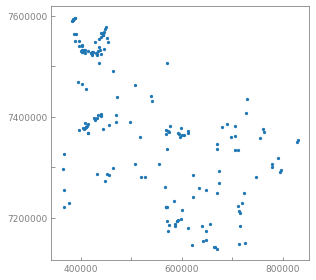

In [10]:
# Plot control points with labels
plots.plot_map_with_control_points(coordinates_utm, group_name, label_size=4, subset=["X", "Y"],
                                   show_labels=False,
                                  skip_xaxis_label=2, skip_yaxis_label=2, 
                                  skip_xaxis_start=1, skip_yaxis_start=1)

In [11]:
# Show unique zone letters and zone numbers of utm coordinates
coordinates_utm["ZoneNumber"].unique()
coordinates_utm["ZoneLetter"].unique()

array([1], dtype=int64)

array(['W'], dtype=object)

In [12]:
# Calculate minimum and maxmin lag distance between two points of the dataset
distance_matrix = krigingtools.calculate_and_sort_square_distance_matrix(coordinates_utm[["X", "Y"]])

min_lag_distance = np.amin(distance_matrix)
max_lag_distance = np.amax(distance_matrix)
min_lag_distance, max_lag_distance

(1.8831705021028549, 559831.3938417885)

(array([ 740.,  796.,  894.,  924., 1068.,  952.,  744.,  884.,  942.,
        1144., 1398., 1400., 1076., 1122., 1100., 1178., 1274., 1208.,
        1236.,  868.,  760.,  766., 1018.,  830.,  934.,  834.,  864.,
         754.,  542.,  706.,  708.,  620.,  508.,  284.,  264.,  214.,
         176.,   68.,   24.,   40.]),
 array([1.88317050e+00, 1.39976209e+04, 2.79933587e+04, 4.19890965e+04,
        5.59848342e+04, 6.99805720e+04, 8.39763098e+04, 9.79720475e+04,
        1.11967785e+05, 1.25963523e+05, 1.39959261e+05, 1.53954999e+05,
        1.67950736e+05, 1.81946474e+05, 1.95942212e+05, 2.09937950e+05,
        2.23933687e+05, 2.37929425e+05, 2.51925163e+05, 2.65920901e+05,
        2.79916639e+05, 2.93912376e+05, 3.07908114e+05, 3.21903852e+05,
        3.35899590e+05, 3.49895327e+05, 3.63891065e+05, 3.77886803e+05,
        3.91882541e+05, 4.05878278e+05, 4.19874016e+05, 4.33869754e+05,
        4.47865492e+05, 4.61861229e+05, 4.75856967e+05, 4.89852705e+05,
        5.03848443e+05, 5.1784

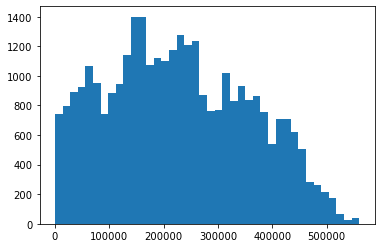

In [13]:
plt.hist(distance_matrix.flatten(), bins=40)

In [14]:
np.where(distance_matrix == 0)

(array([], dtype=int64), array([], dtype=int64))

## Critical distance estimation
___

In [15]:
# Range (lag distance at which the sill is reached; in meters)

# Depending on how many principal components you will use, 
# you will have to add more entries to this list.

# Modified the range since variograms are not correct yet
# range_ = [100000] * 15
range_ = [120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 100000, 100000, 100000, 100000, 100000, 100000]



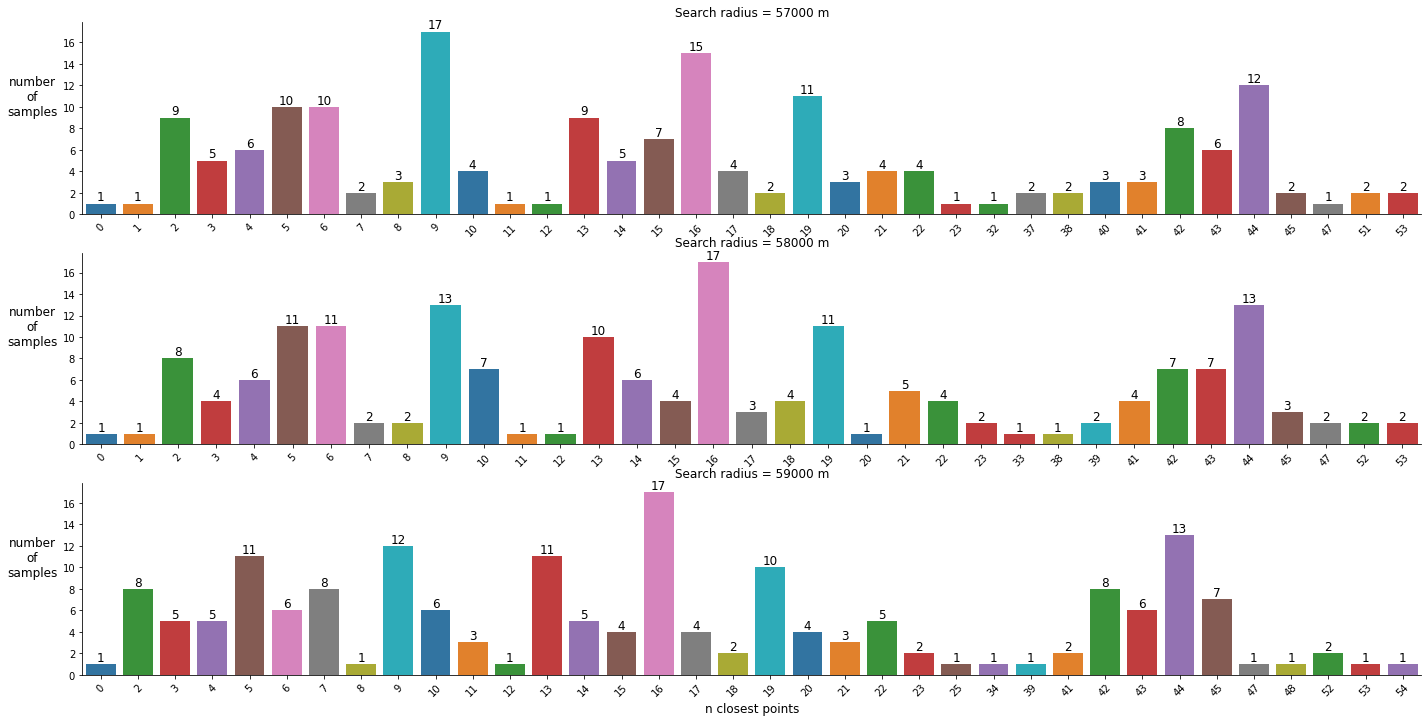

In [16]:
# You can adjust the radius parameters below to change the slider settings
# to visualize the figures interactively
plots.interactive_plot_search_radius(coordinates_utm, orient='rows', 
                                     radius_default=58000, # Default slider position
                                     radius_min=30000,  # Slider start
                                     radius_max=60000, # Slider stop
                                     radius_step=1000,  # Slider step
                                     radius_offset=1000) # Offset between visualizations shown

# The x-axis stands for 'n_neighbours'

In [17]:
# Critical distance (in meters)
# This is the distance where at least 95% of your samples
# will have at least 3 neighbours within that distance

# You can refine this value later on, or we can use the range 
# instead of the critical distance as the only value for the search radius
critical_distance = 59000

In [18]:
# This is basically creating a list of how many neighbours each data point has 
# within the critical_distance and within the range
nvalues_control_points = {}

for radius in (0.05, critical_distance, range_[0]):
    temp = krigingtools.find_points_within_search_radius(
               krigingtools.calculate_and_sort_square_distance_matrix(coordinates_utm),
               search_radius=radius # 'search_radius' should be equal to 'radius' here, not 'critical_distance'
           )
    nvalues_control_points[radius] = pd.Series(temp, index=coordinates_utm.index)
    
# You're performing a calculation in a for loop so we want to check how many neighbours each data point has 
# within the specified radius in the tuple (0.05, critical_distance, range_[0]). 
# So for each of these specified distances, the function will be executed and 
# the result stored in the nvalues_control_points dictionary

In [19]:
# Number of samples that may still have less than 3 neighbours within the critical distance
number_of_control_points * 0.05

8.950000000000001

In [20]:
# Check number of samples outside of critical distance
samples_outside_critical_distance = nvalues_control_points[critical_distance][nvalues_control_points[critical_distance] < 3].index.tolist()
len(samples_outside_critical_distance)

# 0.05 sample above 8.95

9

In [21]:
# Overview of samples that are outside search_radius
mineralogy_pca_df.loc[samples_outside_critical_distance, :]

,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,PC11,PC12,PC13
1556,-0.303748,0.457423,2.333652,-0.415178,-0.249226,0.957488,-0.502017,-0.619919,0.187869,0.171171,-0.203019,0.009588,5.116961e-16
1668,-0.232650,-1.500949,-0.410198,-0.907362,-1.149123,-0.419819,0.346947,-0.104328,0.046686,-0.390153,-0.065519,-0.056115,1.363996e-17
2261,-1.214433,-1.042020,-1.200151,0.486425,0.182759,0.260468,0.066605,-0.142634,-0.162857,0.511915,-0.087455,0.078351,-2.446064e-16
2461,-1.014077,0.730160,0.585557,-0.901819,-0.424560,0.792821,0.037765,0.264654,0.012693,0.325221,0.052917,0.009922,6.577982e-16
3010,0.984269,-0.917884,-1.745811,-0.189842,1.094667,-0.222189,-0.086035,0.541953,-0.127996,-0.533390,-0.190629,0.091716,6.287360e-16
3090,-1.504130,-1.032494,-1.395213,-0.041966,0.710947,0.353525,0.319524,-0.155352,-0.046667,-0.043131,-0.089953,0.017798,-1.269380e-16
3482,2.754887,1.448438,-0.517775,-1.122225,1.755345,-0.810316,-0.022513,-0.208855,-0.039964,0.409651,0.056388,0.046492,5.724513e-16
3588,-1.366573,-0.748171,-1.707073,-2.201738,-0.125877,0.283749,-0.058281,0.004962,-0.470806,0.383404,0.017158,-0.004123,6.441438e-16
3872,-1.343340,2.612023,0.660477,-0.413577,-0.178130,0.149604,0.126322,0.126274,0.123119,0.336556,-0.088558,0.083955,9.129874e-16


____

## Create high resolution grids
____

In [22]:
# Determine (wide) grid boundaries
X = coordinates_utm.iloc[:, 0].values
Xmin = np.min(X) - critical_distance * 1.05
Xmax = np.max(X) + critical_distance * 1.05

Y = coordinates_utm.iloc[:, 1].values
Ymin = np.min(Y) - critical_distance * 1.05, 
Ymax = np.max(Y) + critical_distance * 1.05

coordinates_boundaries = np.array([[Xmin, Xmax], [Ymin, Ymax]])
coordinates_boundaries

array([[302217.4705087786, 890937.291295761],
       [(7076873.143244307,), 7657479.493387843]], dtype=object)

In [23]:
# Set approximate number of points along each axis
n_points = 600

temp = {}
x, y = coordinates_boundaries

temp["x_start (m)"] = int(np.floor(x[0]))
temp["x_end (m)"] = int(np.floor(x[1]))
temp["y_start (m)"] = int(np.floor(y[0]))
temp["y_end (m)"] = int(np.floor(y[1]))

print("x", x)
print("y", y)

temp["x_range (m)"] = int(np.floor(x[1])) - int(np.floor(x[0]))
temp["y_range (m)"] = int(np.floor(y[1])) - int(np.floor(y[0]))
print("x range: ", temp["x_range (m)"])
print("y range: ", temp["y_range (m)"])

ranges = {"x": temp["x_range (m)"],
          "y": temp["y_range (m)"],
         }

threshold = 10000000
for dimension, ranger in ranges.items():
    if ranger < threshold:
        smallest_dimension = dimension
        threshold = ranger
print("smallest dimension", smallest_dimension)

x_spacing, dx = np.linspace(x[0], x[1], n_points, retstep=True)
y_spacing, dy = np.linspace(y[0], y[1], n_points, retstep=True)

steps = {"x": dx,
         "y": dy,
        }

print("theoretical x spacing: ", dx)

xgrid = np.arange(x[0]-dx, x[1]+dx, steps[smallest_dimension])
ygrid = np.arange(y[0]-dy, y[1]+dy, steps[smallest_dimension])

print("actual x spacing: ", xgrid[1] - xgrid[0])
print("actual y spacing: ", ygrid[1] - ygrid[0])

temp["x_spacing (m)"] = np.round(xgrid[1] - xgrid[0], 2)
temp["y_spacing (m)"] = np.round(ygrid[1] - ygrid[0], 2)

print("Number of points: ", len(xgrid) * len(ygrid))
print("xy grid: ", len(xgrid), len(ygrid), "\n")

temp["#xgrid_points"] = len(xgrid)
temp["#ygrid_points"] = len(ygrid)
temp["#total_grid_nodes"] = len(xgrid) * len(ygrid)

coordinates_grids = [xgrid, ygrid]
coordinates_grids_details = temp

# Assigned to a different variable (name) because later on 'grid' gets used in the code
grid = coordinates_grids

x [302217.4705087786 890937.291295761]
y [(7076873.143244307,) 7657479.493387843]
x range:  588720
y range:  580606
smallest dimension y
theoretical x spacing:  982.8377642520575
actual x spacing:  969.2927381361369
actual y spacing:  969.2927381359041
Number of points:  366610
xy grid:  610 601 



## Classification map
___

We will have to decide on a certain classification scheme before we could use this.  
Another option might be to use a condensed version of the 'type_granite' column.

**Yep**

## Detrending
____

In [24]:
# Check if there is a trend present in the data
# This is the case if R² is above say 0.70 

for component in mineralogy_pca_df.columns.tolist()[:-1]:
    for order in [1, 2]:
        print("R² for", component, "order =", order, ":")
        detrending.detrend(coordinates_utm, 
                           mineralogy_pca_df[component], 
                           order=order, 
                           verbose=False, 
                           plot_points=False)[1]

R² for PC01 order = 1 :


0.008727423933632794

R² for PC01 order = 2 :


0.014134607784429987

R² for PC02 order = 1 :


0.03283582975397481

R² for PC02 order = 2 :


0.03328464734351

R² for PC03 order = 1 :


0.0900429523827202

R² for PC03 order = 2 :


0.09534044822696164

R² for PC04 order = 1 :


0.03323641426239021

R² for PC04 order = 2 :


0.056802391857463386

R² for PC05 order = 1 :


0.045279819376259356

R² for PC05 order = 2 :


0.07228747546658354

R² for PC06 order = 1 :


0.07167795709173708

R² for PC06 order = 2 :


0.10804616247752996

R² for PC07 order = 1 :


0.04513115725154471

R² for PC07 order = 2 :


0.06627963716600771

R² for PC08 order = 1 :


0.01006816230529195

R² for PC08 order = 2 :


0.014785812661872288

R² for PC09 order = 1 :


0.013796779049204289

R² for PC09 order = 2 :


0.016735628644211076

R² for PC10 order = 1 :


0.10570794204669332

R² for PC10 order = 2 :


0.12418336087993798

R² for PC11 order = 1 :


0.031454887037930424

R² for PC11 order = 2 :


0.03635347811943257

R² for PC12 order = 1 :


0.045141743240848076

R² for PC12 order = 2 :


0.07020781283619493

## Variogram modelling
___

* Variogram model (str)
* Sill (float)
* Range (float)
* Nugget (float)
* Number of lag bins (int)
* Weighted (Bool)

In [25]:
# Nugget (variance at lag=0 metric)

# Since we are not dealing with point count data here,
# we can not use the formulas from our paper we have talked about
# Therefore I would just start with nugget=0 and perhaps later change this

# Depending on how many principal components you will use, 
# you will have to add more entries to this list.
nugget_ = [0.824, 0.359, 0.797, 0.519, 0.434, 0.313, 0.0806, 0.103, 0.0881, 0., 0., 0., 0., 0., 0.]

In [26]:
PC_nr_list = [nr[2:] for nr in mineralogy_pca_df.columns]
PC_nr_list

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13']

In [27]:
# Sill (total variance metric)

# A 'list comprehension' construction is used here
sill_ = [mineralogy_pca_df.loc[:, f"PC{i}"].values.var(ddof=1) 
         for i in PC_nr_list]

In [28]:
# Variogram model parameters dictionary

variogram_model_parameters = {}

for i, PC in enumerate(mineralogy_pca_df.columns):
    parameters = {}
    parameters["sill"] = sill_[i]
    parameters["range"] = range_[i]
    parameters["nugget"] = nugget_[i]
        
    variogram_model_parameters[PC] = parameters

In [29]:
# Variogram model

# You can choose between ["exponential", "linear", "spherical", "power", "gaussian"]
# see https://pykrige.readthedocs.io/en/latest/variogram_models.html for equations
variogram_model = "exponential"

In [30]:
# Number of lag bins

n_lags = int(np.floor(np.sqrt(coordinates_utm.shape[0])))
n_lags

13

In [31]:
# Set utm coordinates to use in variogram

X = coordinates_utm.iloc[:, 0].values
Y = coordinates_utm.iloc[:, 1].values

PC01
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 1.922011730447983
Full Sill: 2.7460117304479827
Range: 120000
Nugget: 0.824 



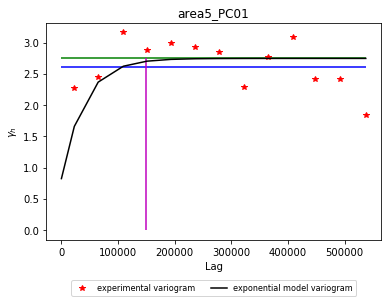

Calculating statistics on variogram model fit...
PC02
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 1.4381968759362376
Full Sill: 1.7971968759362376
Range: 120000
Nugget: 0.359 



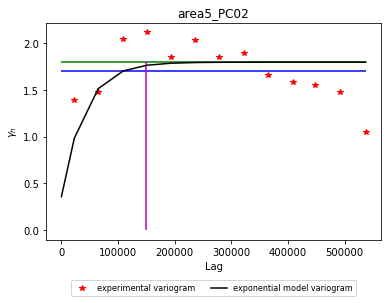

Calculating statistics on variogram model fit...
PC03
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.5310986845632534
Full Sill: 1.3280986845632534
Range: 120000
Nugget: 0.797 



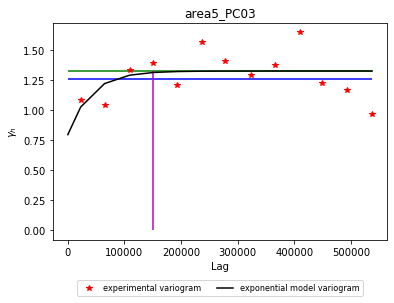

Calculating statistics on variogram model fit...
PC04
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.3465113329385634
Full Sill: 0.8655113329385634
Range: 120000
Nugget: 0.519 



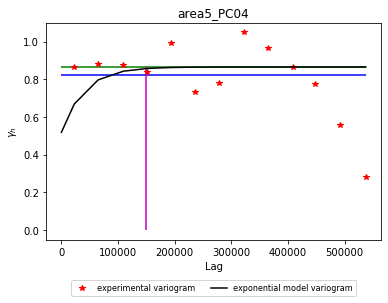

Calculating statistics on variogram model fit...
PC05
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.18557822451242095
Full Sill: 0.619578224512421
Range: 120000
Nugget: 0.434 



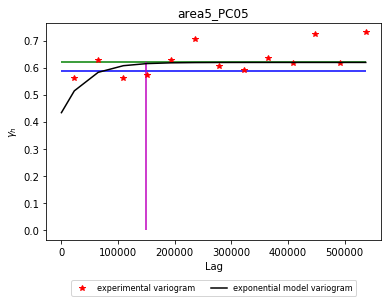

Calculating statistics on variogram model fit...
PC06
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.1346645961485909
Full Sill: 0.4476645961485909
Range: 120000
Nugget: 0.313 



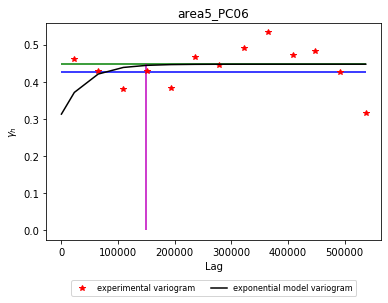

Calculating statistics on variogram model fit...
PC07
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.1880623847966233
Full Sill: 0.2686623847966233
Range: 120000
Nugget: 0.0806 



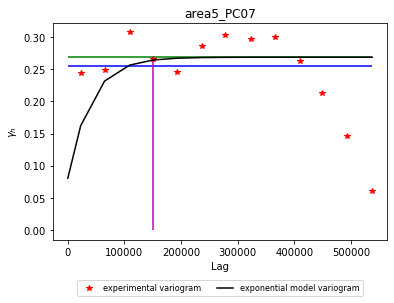

Calculating statistics on variogram model fit...
PC08
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.04369219666559977
Full Sill: 0.14669219666559977
Range: 120000
Nugget: 0.103 



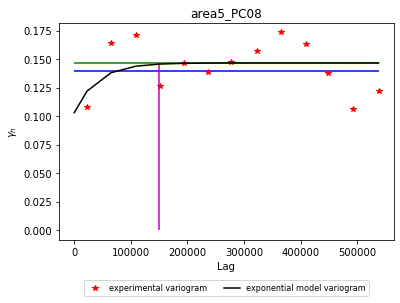

Calculating statistics on variogram model fit...
PC09
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.021965433306858226
Full Sill: 0.11006543330685822
Range: 120000
Nugget: 0.0881 



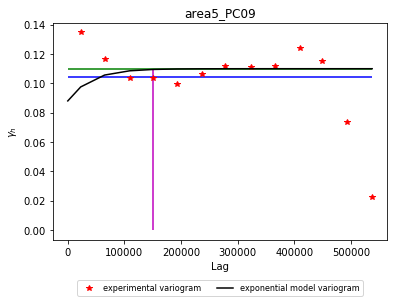

Calculating statistics on variogram model fit...
PC10
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.06338634343888819
Full Sill: 0.06338634343888819
Range: 100000
Nugget: 0.0 



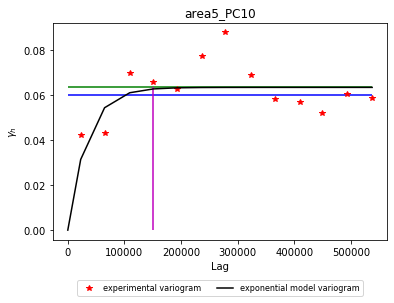

Calculating statistics on variogram model fit...
PC11
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.010574313953417897
Full Sill: 0.010574313953417897
Range: 100000
Nugget: 0.0 



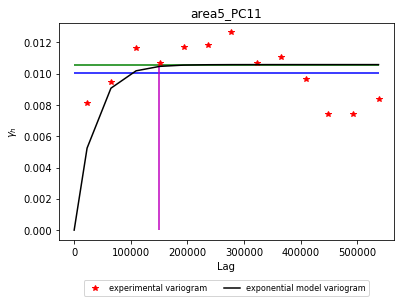

Calculating statistics on variogram model fit...
PC12
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.004457443318874745
Full Sill: 0.004457443318874745
Range: 100000
Nugget: 0.0 



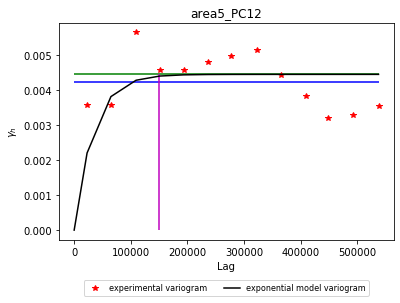

Calculating statistics on variogram model fit...
Wall time: 4.67 s


In [32]:
%%time
# Initialize empty dictionary
variograms = {}

# Loop though the diiferent principal components
for component in mineralogy_pca_df.columns.tolist()[:-1]:
    print(component)
    # Subset principal component to use
    data = mineralogy_pca_df.loc[:, component].values
    variograms[component] = \
        OrdinaryKriging(X, Y, data,
                        variogram_model='exponential',
                        variogram_parameters=variogram_model_parameters[component],
                        nlags=n_lags,
                        verbose=True,
                        enable_statistics=False,
                        enable_plotting=True,
                        weight=True,
                        saveplot=True,
                        coordinates_type='euclidean',
                        saveloc="../_FIGURES/variograms/",
                        principal_component=component,
                        pluton=group_name,
                        show_nlag_pairs=False, # Turn off displaying number of lag pairs in lag bin
                        show_range_determine_guide=True, # 0.95 * sill highlighted with blue line to help determining range
                        range_estimate=150000) # Pass in value in meters to display a line at range estimate; set value to None to not display line
    
# NOTE that ideally Q1 is close to zero, Q2 is close to 1, and cR is as small as possible.

## Leave One Out Cross Validation (LOOCV) of PCA
____

In [33]:
# If you have run the cross validation before you can load the results by
# running this cell and don't have to run the next cell anymore.
CV_results = preproc.load_obj("CV_results_fast")

In [34]:
# Use this cross validation to check the hyper-parameters of your chosen variogram model 
# such as the search_radius, variogram_model, lag_bins etc.

# Cross validation parameter dictionary to use
# You can remove or add options here which will decrease or increase the number 
# of combinations of parameters the cross validation will run
cv_param_dict = {}

for component in mineralogy_pca_df.columns.tolist()[:-1]:
    cv_param_dict[component] = {"method": ["ordinary"],
                                "variogram_model": ["exponential", "spherical"],
                                "variogram_model_parameters": [variogram_model_parameters[component]],
                                "nlags": [n_lags],
                                "weight": [True],
                                "n_closest_points": [number_of_control_points],
                                "search_radius": [range_[0]]
                                }

# The CV function below uses parallel processing to speed things up
# Your CPU will thus reach 100% probably
# To reduce the number of parallel processes to use you can change the following value
# Defaults to -1 to use all available CPU cores; change to number between 1 and 8 e.g. 
# depending on how many cores your CPU has
n_jobs = -1 

In [35]:
%%time
# Run CV and get estimators (using default MSE scorer)

# Instead of running the CV for all the PCs, let's start with only the first 3 
# to get an idea of what are the best parameters to use for the first 3 PCs.
# In a later step we can then obtain the best parameters for all PCs that have 
# a sensible variogram; here this would mean up to and including PC09.
# To specify which PCs to use, you can pass them in as list to the 'components_to_use' variable

# Another change I've made, is that instead of performing leave-one-out-CV 
# where the train set is equal to n_sample - 1 and the test set is equal to 1,
# it makes sense to here use a different strategy, since you're dealing with many more samples.
# Therefore I've included the 'cv_folds' parameter where you can specify 
# the number of train/test groups you want to use during CV
# Let's start with ten groups, which basically means that 
# you use 90% of the samples as train set and 10% as test test
# and this in 10 combinations.

# A a later stage we could change the CV to use a statified cv_fold
# meaning that it ensures for example that for every train/test grouping of the 10 groups
# equal numbers of samples of spcified grouping variable are used 
# (for example your time category or classification later on)

# I've also included the '%%time' statement at the beginning of the cell,
# so that at the end of the calculation you can see how much time it took.

# Have a look here if you want some background info on the CV method used:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

estimators = loocv.perform_loocv(mineralogy_pca_df,
                                 coordinates_utm,
                                 cv_param_dict,
                                 n_jobs=n_jobs,
                                 cv_folds=10,
                                 components_to_use=[f"PC0{i}" for i in range(1, 10)])

PC01
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    2.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    2.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.0s finished
C:\Users\Sebastian\Anaconda3\envs\main\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


PC02
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


PC03
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC04
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.1s remaining:    0.1s


PC05
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


PC06
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC07
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


PC08
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC09
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished


Wall time: 5.55 s


In [36]:
# Convert estimators to dict of dataframes
CV_results = loocv.convert_scores_to_df(estimators)

In [37]:
# Save CV_results to pickle file for easy use later
# These are the results from the 56min CV above (with only first 3 PCs)
preproc.save_obj(CV_results, "CV_results_summarized")

In [38]:
# Save CV_results to pickle file for easy use later
# These are the results from the 2min CV above (with only first 9 PCs, simple parameters)
preproc.save_obj(CV_results, "CV_results_fast")

In [39]:
# Quick look at best results per PC
loocv.print_best_scores(CV_results)

PC01
rank_test_score                    2
mean_test_score              2.09663
std_test_score              0.799783
mean_train_score         5.01382e-31
param_method                ordinary
param_variogram_model    exponential
param_search_radius           120000
Name: 0, dtype: object


PC02
rank_test_score                    2
mean_test_score               1.4435
std_test_score              0.611376
mean_train_score          3.5377e-31
param_method                ordinary
param_variogram_model    exponential
param_search_radius           120000
Name: 0, dtype: object


PC03
rank_test_score                    2
mean_test_score              1.14822
std_test_score              0.683569
mean_train_score         8.52606e-32
param_method                ordinary
param_variogram_model    exponential
param_search_radius           120000
Name: 0, dtype: object


PC04
rank_test_score                    2
mean_test_score             0.801556
std_test_score              0.455039
mean_train_score 

## Calculating predictions for best model
____

In [40]:
# Here you can specify the components and search_radii you want to use 
# when performing the kriging and performing the postprocessing calculations
components_to_use = [f"PC0{i}" for i in range(1, 4)]
search_radii = [range_[0]]

In [41]:
estimators_final = {}

for component in components_to_use:  # Changed to only first 9 PCs
    for radius in search_radii:  # Removed critical_distance
        for variable_to_fit in ["estimates"]:

            estimators_final[f"{component}_{radius}_{variable_to_fit}"] = \
                Krige(method='ordinary',
                      variogram_model=variogram_model,
                      variogram_model_parameters=variogram_model_parameters[component],
                      nlags=n_lags,
                      weight=True,
                      n_closest_points=number_of_control_points,
                      search_radius=radius,
                      variable_to_fit=variable_to_fit)

In [42]:
# Run this cell if you have previously run the next cell and saved its outcome
kriging_predictions = preproc.load_obj("kriging_predictions")

In [43]:
%%time
# You can again change the n_jobs to lower the #CPU cores used for parallel processing
# Also set the cv_folds variable below
cv_folds = 10

kriging_predictions = {}

for component in components_to_use:  # Changed to only first 9 PCs
    for radius in search_radii:  # Removed critical_distance
        for variable_to_fit in ["estimates"]:
            
            # Let's print out the combination to see where we are in the loops
            print(component, radius, variable_to_fit)
            
            kriging_predictions[f"{component}_{radius}_{variable_to_fit}"] = \
                cross_val_predict(estimators_final[f"{component}_{radius}_{variable_to_fit}"], 
                                  X=np.stack((coordinates_utm["X"],
                                              coordinates_utm["Y"]), axis=1),
                                  y=mineralogy_pca_df[component],
                                  cv=cv_folds,
                                  n_jobs=-1,
                                  verbose=5)

PC01 120000 estimates
PC02 120000 estimates
PC03 120000 estimates
Wall time: 106 ms


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s r

In [44]:
preproc.save_obj(kriging_predictions, "kriging_predictions")

## Calculate clr solutions
____

In [45]:
kriging_estimates_df = {}

for radius in search_radii:
    temp = {}
    
    for component in components_to_use:
        key = f"{component}_{radius}_estimates"
        temp[key] = kriging_predictions[key]

    kriging_estimates_df[f"{radius}"] = pd.DataFrame.from_dict(temp)
    kriging_estimates_df[f"{radius}"].index = mineralogy_pca_df.index
    kriging_estimates_df[f"{radius}"].columns = components_to_use
    
    print(f"{radius}")
    kriging_estimates_df[f"{radius}"].head()

120000


,PC01,PC02,PC03
43,0.671886,0.364868,-0.221131
67,-1.044350,0.227255,0.223215
111,-0.364947,0.404235,-0.389834
134,-0.038509,-0.841791,-0.163371
181,-0.139583,-0.711800,-0.148610


In [46]:
kriging_estimates_clr = {}

for ncomp in range(1, len(components_to_use) + 1):
    for radius in search_radii:

        kriging_estimates_clr[f"{ncomp}_{radius}"] = \
            postproc.reverse_pca(mineralogy_pca, 
                                 kriging_estimates_df[f"{radius}"],
                                 mineralogy_clr,
                                 n_comp=ncomp)

In [47]:
solutions_clr = {}

for ncomp in range(1, len(components_to_use) + 1):
    for radius in search_radii:

        solutions_clr[f"{ncomp}_{radius}"] = \
            pd.DataFrame(kriging_estimates_clr[f"{ncomp}_{radius}"], 
                         index=mineralogy_clr.index, 
                         columns=mineralogy_clr.columns)

In [48]:
residuals_clr = {}

for ncomp in range(1, len(components_to_use) + 1):
    for radius in search_radii:

        residuals_clr[f"{ncomp}_{radius}"] = \
            mineralogy_clr.subtract(solutions_clr[f"{ncomp}_{radius}"])

In [49]:
for ncomp in range(1, len(components_to_use) + 1):
    for radius in search_radii:
        temp = pd.merge(residuals_clr[f"{ncomp}_{radius}"], 
                        pd.DataFrame(nvalues_control_points[radius], 
                                     columns=["n_closest_points"]), 
                        left_index=True, 
                        right_index=True)\
                 .sort_values("n_closest_points")
        
        temp.to_excel(f"../_RESULTS/Residuals/residuals_clr_{ncomp}_{radius}_{group_name}.xlsx")

In [50]:
preproc.save_obj(residuals_clr, "residuals_clr")

In [51]:
preproc.save_obj(nvalues_control_points, "nvalues_control_points")

## Model selection
____

In [52]:
# Get MSPE_Q values and select best model based on it
# Make sure the selected model passes the Hotelling's T² 2-sample test above, though
MSPE_Q = {}
best_MSPE_Q = 1000

for ncomp in range(1, len(components_to_use) + 1):
    for radius in search_radii:

        # Calculate MSPE_Q from clr residuals
        MSPE_Q_temp = np.mean(np.sum(residuals_clr[f"{ncomp}_{radius}"] ** 2, axis=1), axis=0)

        if MSPE_Q_temp < best_MSPE_Q:
            # Store best MSPE_Q en corresponding model
            best_MSPE_Q = MSPE_Q_temp
            selected_model = f"{ncomp}_{radius}"

        MSPE_Q[f"{ncomp}_{radius}"] = MSPE_Q_temp
                
MSPE_Q
best_MSPE_Q
selected_model
selected_model_PCs = selected_model.split("_")[0]

{'1_120000': 7.717541070913257,
 '2_120000': 7.366794329745801,
 '3_120000': 7.185622895984334}

7.185622895984334

'3_120000'

In [53]:
# Number of PCs to use for reverse calculations based on selected model
n_comp = int(selected_model.split("_")[0])
# Whcih PCs to use moving forward
selected_components_to_use = [f"PC{i:02d}" for i in range(1, n_comp + 1)]

In [54]:
selected_components_to_use

['PC01', 'PC02', 'PC03']

## Contour plots
____

In [55]:
nvalues_critical_distance = \
    variograms["PC01"].determine_mask_array(grid[0], 
                                            grid[1], 
                                            search_radius=critical_distance)
mask_critical_distance = nvalues_critical_distance < 3
mask_critical_distance.shape

(179, 2)
(366610, 2)
610 601


(601, 610)

In [56]:
mask_critical_distance[mask_critical_distance == 1].sum()

189308

In [57]:
non_masked_grid_nodes = \
    grid[0].shape[0] * grid[1].shape[0] \
    - mask_critical_distance[mask_critical_distance == 1].sum()

In [58]:
grid_cell_spacing = grid[0][1] - grid[0][0]
grid_cell_area = grid_cell_spacing ** 2

In [59]:
# Pluton area in m²
pluton_area_m2 = non_masked_grid_nodes * grid_cell_area

# Pluton area in km²
pluton_area_km2 = pluton_area_m2 / 1_000_000

In [60]:
pluton_area_km2

166580.26654049603

____

In [61]:
interpolated_dict = preproc.load_obj("interpolated_dict")

In [62]:
# Since my desktop (with 32GB of RAM) ran out of memory,
# I've reduced the grid spacing so that there are fewer grid points 
# to perform the interpolation for

# You could also reduce the number of active CPU cores by decreasing 'n_jobs'
# which would reduce memory consumption
# so that you could still get a more detailed interpolation grid.
# The interpolation will take a bit longer than since 
# not the maximum number of 'workers' can be used in that case.

In [63]:
%%time
interpolated_parallel = Parallel(n_jobs=1)(delayed(
    variograms[component].execute)('masked', 
                     grid[0], 
                     grid[1],
                     mask_critical_distance,
                     n_closest_points=number_of_control_points, 
                     search_radius=range_[0], 
                     backend='loop') for component in components_to_use)

Wall time: 2min 19s


In [64]:
interpolated_dict = {}
for i, item in enumerate(interpolated_parallel, start=1):
    interpolated_dict[f"PC0{i}"] = item

In [65]:
preproc.save_obj(interpolated_dict, "interpolated_dict")

In [66]:
interpolated_array = postproc.convert_grid_to_array_of_scores(interpolated_dict)

interpolated_reverse_pca = postproc.reverse_pca(mineralogy_pca, 
                                                interpolated_array, 
                                                mineralogy_clr, 
                                                n_comp=n_comp)

interpolated_reverse_clr = postproc.reverse_clr(interpolated_reverse_pca, 
                                                mineralogy_clr)

# You will get a FutureWarning here, that's fine

1
2
3
(3, 601, 610)


C:\Users\Sebastian\Anaconda3\envs\main\lib\site-packages\IPython\core\interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [67]:
# Get kriging surface variance for error_budget
var_OK = np.array(pd.DataFrame(interpolated_array).var(axis=0, ddof=1))
var_OK.sum()

1.6992258244399334

In [68]:
# Check if the number of points based on the specified grid is equal to
# the sum of the number of masked points and the number of interpolated points
assert grid[0].shape[0] * grid[1].shape[0] == np.sum(np.isclose(interpolated_reverse_clr.sum(axis=1), 0.0)) + \
                                              np.sum(np.isclose(interpolated_reverse_clr.sum(axis=1), 100.0))

In [69]:
interpolated_modal = {}
for mineral in interpolated_reverse_clr.columns.tolist():
    interpolated_modal[mineral] = np.reshape(interpolated_reverse_clr.loc[:, mineral].values, 
                                             (grid[1].shape[0], grid[0].shape[0]))

In [70]:
# If you get an error related to an non-esixting save location
# Please first create a folder on your pc with the same name that 
# you used for the variable 'group_name'

for mineral, interpolation in interpolated_modal.items(): 
    for variable in ["estimates"]:
        print(interpolation.shape)
        plots.plot_contour_map(interpolation,
                               grid,
                               coordinates_utm,
                               group_name,
                               variable=variable,
                               title=f"{mineral} radius={range_[0]}m {variable} masked {critical_distance}m",
                               show_plot=False,
                               single_mineral=True,
                               mineral=mineral,                               
                               label_pos = (0.03, 0.94),
                               skip_xaxis_label=2,
                               skip_yaxis_label=2,
                               skip_xaxis_start=1,
                               skip_yaxis_start=1,
                               marker_symbol='.',
                               marker_size=0.1,
                               marker_color='r',)
        
# Added some options to function so that yu can easily change the appearance 
# of the markers used to show the position of the control points

(601, 610)
SiO2
(601, 610)
TiO2
(601, 610)
Al2O3
(601, 610)
Fe2O3
(601, 610)
FeO
(601, 610)
MnO
(601, 610)
MgO
(601, 610)
CaO
(601, 610)
Na2O
(601, 610)
K2O
(601, 610)
P2O5
(601, 610)
l.i.
(601, 610)
oth


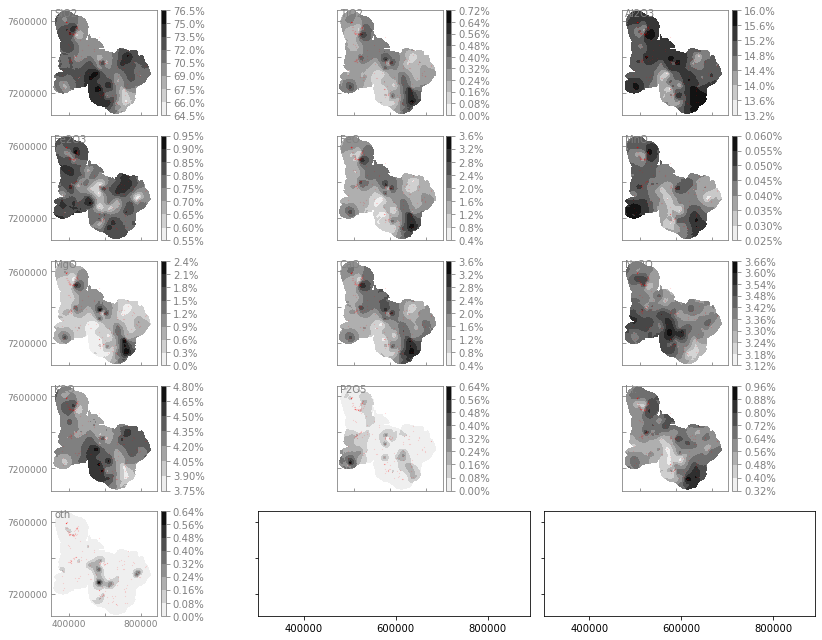

In [71]:
# Specify how many rows and columns you want to use in the following figure
# This will ofcourse depend an the number of variables you would like to plot
# You can also set the figure size
n_cols = 3
n_rows = 5

# Figure with single mineral maps as subplots
plots.plot_contour_map_all(interpolated_modal,
                           grid,
                           coordinates_utm,
                           group_name,
                           title=f"radius={range_[0]}m masked {critical_distance}m",
                           show_plot=True,
                           label_pos = (0.03, 0.94),
                           skip_xaxis_label=2,
                           skip_yaxis_label=2,
                           skip_xaxis_start=1,
                           skip_yaxis_start=1,
                           marker_size=0.1,
                           marker_color='r',
                           marker_symbol='.',
                           figsize=(12, 9),
                           ncols=n_cols,
                           nrows=n_rows,
                           sharex=True,
                           sharey=True)

## QAPF maps
____

In [87]:
interpolated_mineralogy = pd.read_excel("../_CIPW/CIPW/AREA5/qapf.xlsx")

In [88]:
interpolated_reverse_clr = pd.read_excel("../_CIPW/CIPW/AREA5/interpolated_data.xlsx")

In [89]:
interpolated_mineralogy = interpolated_mineralogy.set_index(" SAMPLE")

In [90]:
interpolated_mineralogy

,Q,P,K,QAPF
SAMPLE,,,,
5249,27.208199,36.628164,27.326432,monzo granite
5250,27.167389,36.656974,27.315743,monzo granite
5251,27.126472,36.685809,27.305004,monzo granite
5252,27.085567,36.714535,27.294222,monzo granite
5253,27.044643,36.743102,27.283505,monzo granite
...,...,...,...,...
363036,29.914730,34.397391,28.094479,monzo granite
363037,29.915543,34.396695,28.094040,monzo granite
363038,29.916504,34.395953,28.093617,monzo granite


In [91]:
interpolated_mineralogy["QAPF_numbers"] = interpolated_mineralogy["QAPF"].map(qapf.QAPF_upper_regions_numbers)

In [92]:
interpolated_mineralogy

,Q,P,K,QAPF,QAPF_numbers
SAMPLE,,,,,
5249,27.208199,36.628164,27.326432,monzo granite,5
5250,27.167389,36.656974,27.315743,monzo granite,5
5251,27.126472,36.685809,27.305004,monzo granite,5
5252,27.085567,36.714535,27.294222,monzo granite,5
5253,27.044643,36.743102,27.283505,monzo granite,5
...,...,...,...,...,...
363036,29.914730,34.397391,28.094479,monzo granite,5
363037,29.915543,34.396695,28.094040,monzo granite,5
363038,29.916504,34.395953,28.093617,monzo granite,5


In [93]:
interpolated_mineralogy_QAPF = pd.merge(interpolated_reverse_clr, interpolated_mineralogy, 
                                        left_index=True, right_index=True, how='outer')\
                                 .drop(interpolated_reverse_clr.columns, axis=1)

interpolated_mineralogy_QAPF = interpolated_mineralogy_QAPF.fillna(0)
interpolated_mineralogy_QAPF

,Q,P,K,QAPF,QAPF_numbers
0,0.0,0.0,0.0,0,0.0
1,0.0,0.0,0.0,0,0.0
2,0.0,0.0,0.0,0,0.0
3,0.0,0.0,0.0,0,0.0
4,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...
366605,0.0,0.0,0.0,0,0.0
366606,0.0,0.0,0.0,0,0.0
366607,0.0,0.0,0.0,0,0.0
366608,0.0,0.0,0.0,0,0.0


In [94]:
interpolated_mineralogy_QAPF_reshape = np.reshape(interpolated_mineralogy_QAPF["QAPF_numbers"].values, (grid[1].shape[0], grid[0].shape[0]))

In [95]:
values_to_plot = list(np.sort(interpolated_mineralogy_QAPF["QAPF_numbers"].unique()))[1:]
values_to_plot

[5.0]

In [96]:
# Need to have correct excel file with area's control points' CIPW-QAPF classification
mineralogy_QAPF = pd.read_excel("../_CIPW/CIPW/AREA5/QAPF_control_points.xlsx", index_col=0)

In [97]:
QAPF_to_plot = pd.merge(coordinates_utm, mineralogy_QAPF[["QAPF"]], left_index=True, right_index=True)

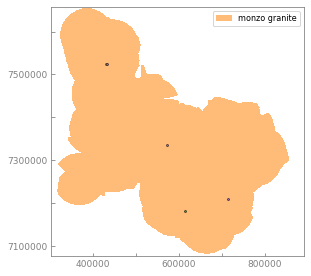

In [98]:
plots.plot_contour_map_interpolated_QAPF(interpolated_mineralogy_QAPF_reshape, grid, QAPF_to_plot, f"{group_name}", values_to_plot=values_to_plot,
                                         skip_xaxis_label=2, skip_yaxis_label=2, skip_xaxis_start=1, skip_yaxis_start=1, show_qapf_control_points=True)

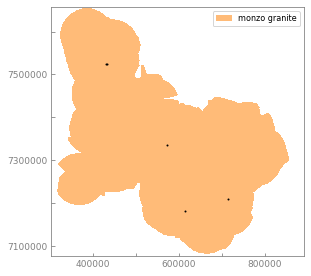

In [99]:
plots.plot_contour_map_interpolated_QAPF(interpolated_mineralogy_QAPF_reshape, grid, QAPF_to_plot, f"{group_name}", values_to_plot=values_to_plot,
                                         skip_xaxis_label=2, skip_yaxis_label=2, skip_xaxis_start=1, skip_yaxis_start=1, show_qapf_control_points=False, no_legend=False)

---

## Biplots
____

Not relevant for now

## Simulations
____

Not relevant for now

## Error budget
____

In [72]:
# A = Variance of kriging surface
# B = mean squared prediction error (MSPE)
# C = Sum of nugget
# D = Total variance based on simulation (not yet available)
# E = Variance of original data set

error_budget = {}

for radius in search_radii:
    for ncomp in range(1, len(components_to_use) + 1):
        A = var_OK[:ncomp].sum()
        B = np.mean(np.sum(residuals_clr[f"{ncomp}_{radius}"] ** 2, axis=1), axis=0) # MSPE
        C = np.array(nugget_)[:ncomp].sum()
        D = np.nan
        E = mineralogy_clr.var(axis=0).sum()
        

        error_budget[f"{ncomp}_{radius}"] = [A, B, C, D, E]

In [73]:
error_budget_df = \
    ttest.convert_summary_test_results_to_df(error_budget, 
                                             variable_names=["VAR(OK)",
                                                             "MSPE", 
                                                             "S_nugget", # Sum of nuggets
                                                             "VAR(TOTAL)",
                                                             "VAR(DATA)"], 
                                             order=["search_radius", 
                                                    "#PCs"])
error_budget_df

,search_radius,#PCs,VAR(OK),MSPE,S_nugget,VAR(TOTAL),VAR(DATA)
0,120000,1,0.755951,7.717541,0.824,NaN,8.4079
1,120000,2,1.403373,7.366794,1.183,NaN,8.4079
2,120000,3,1.699226,7.185623,1.980,NaN,8.4079


In [74]:
error_budget_df.to_excel(f"../_RESULTS/Error_budget/error_budget_{group_name}.xlsx")

------


## variance for each time class

In [75]:
metadata

,type_granite,time,massif,sampler,others,sampler+year
43,Granite,K,Iul'tin massif,NaN,"Oth.:B2o3-0.0l,co2-0.08","A.I.Kyshtymov,1959"
67,Granite-porphyry subalkaline,Pg,Linliney massif,NaN,Oth.:B2o3-0.17,"E.K.Boborykin,1955"
111,Granite-porphyry,K,Kenga massif,L.A.Finogentova,Det:H2o+-0.27,"E.A.Makarov,1975"
134,Granite medium-grained,K,Iul'tin massif,NaN,Det.:H2o+-0.36,"E.G.Bordyugov,1964"
181,Granite medium-grained,K,Iul'tin massif,NaN,Det:H2o+-0.25,"E.G.Bordyugov,1964"
...,...,...,...,...,...,...
4562,Quartz diorite,K,NaN,NaN,NaN,"V.I.Stavitsky,1959"
4594,Quartz diorite,K,Yaayakan massif,NaN,NaN,"S.P.Stoyalov,1961"
4628,Diorite,K,Vennlem Southern massif,o Z.I.Karpicheva,NaN,"V.K.Sadakov,1963"
4643,Diorite,K,Vennlem Southern massif,Z.I.Karpicheva,NaN,"V.K.Sadakov,1963"


In [76]:
metadata['time'].value_counts()

K     164
Pg     13
Mz      2
Name: time, dtype: int64

In [77]:
mineralogy_clr1 = mineralogy_clr.loc[metadata['time'] == 'K']
mineralogy_clr2 = mineralogy_clr.loc[metadata['time'] == 'Pg']
mineralogy_clr3 = mineralogy_clr.loc[metadata['time'] == 'Mz']

In [78]:
mineralogy_clr3

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth
2235,4.455968,-1.156177,2.974054,0.160437,0.381517,-3.721127,-0.700702,0.468528,1.592079,1.621207,-0.830755,-3.027980,-2.217049
2858,4.064653,-0.950321,2.581778,-1.090083,0.992479,-2.581738,0.308634,0.614665,0.494037,1.347907,-2.699521,-0.701425,-2.381067


In [79]:
print('variance for subset K is' ,  mineralogy_clr1.var(axis=0).sum())
print('variance for subset Pg is' ,  mineralogy_clr2.var(axis=0).sum())
print('variance for subset Mz is' ,  mineralogy_clr3.var(axis=0).sum())

variance for subset K is 8.261464738109241
variance for subset Pg is 9.19432895584937
variance for subset Mz is 7.418607834618342


--------

In [80]:
interpolated_reverse_clr

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
366605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
366606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
366607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
366608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
interpolated_reverse_clr.to_excel("../_CIPW/CIPW/AREA5/interpolated_data.xlsx")